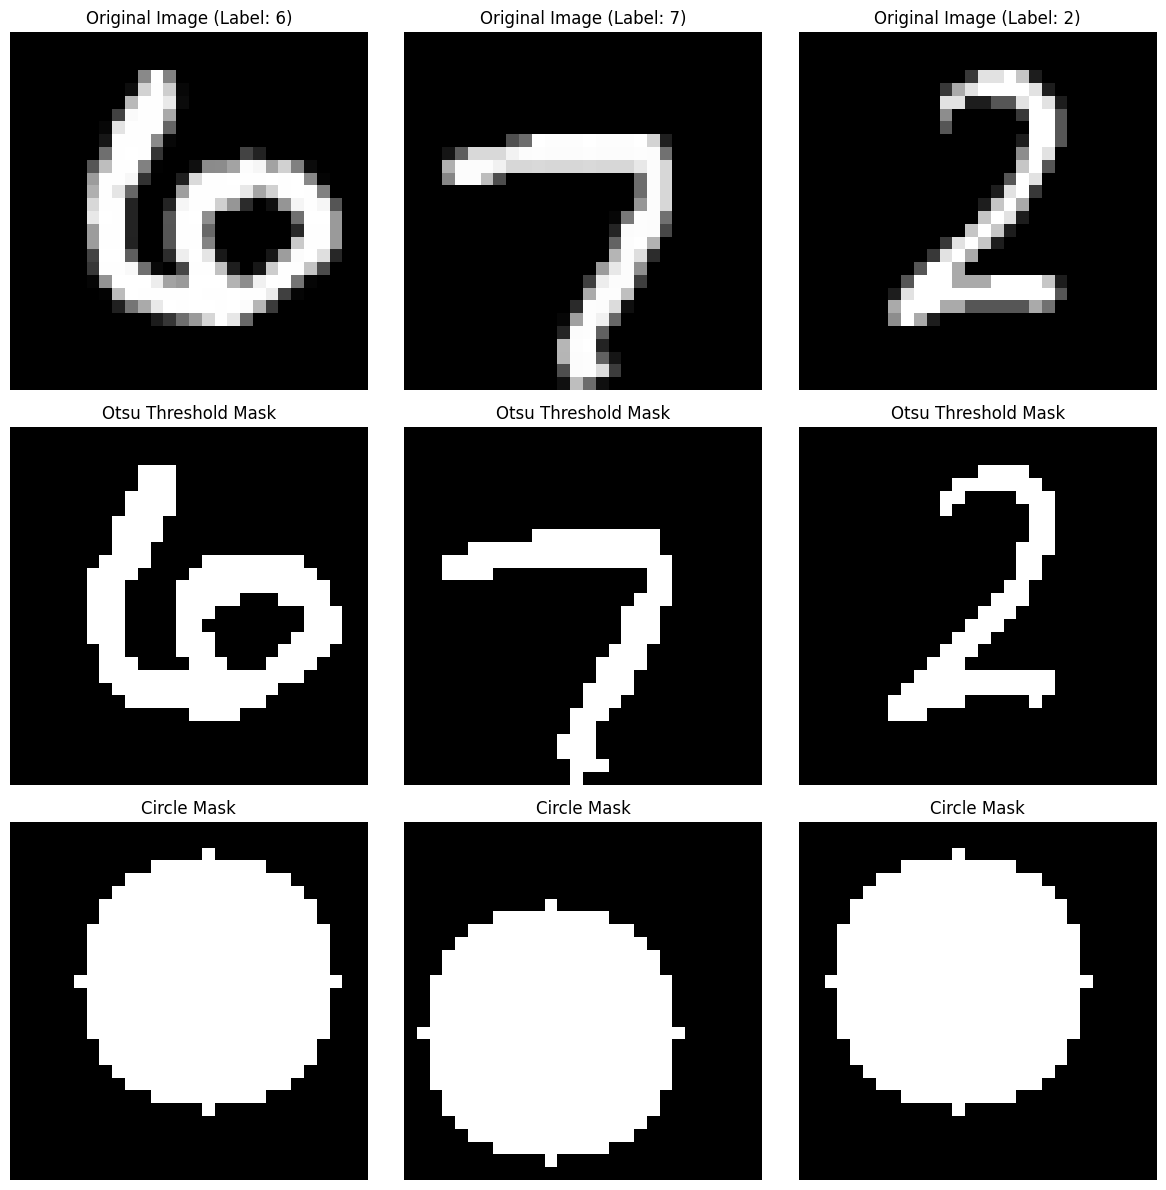

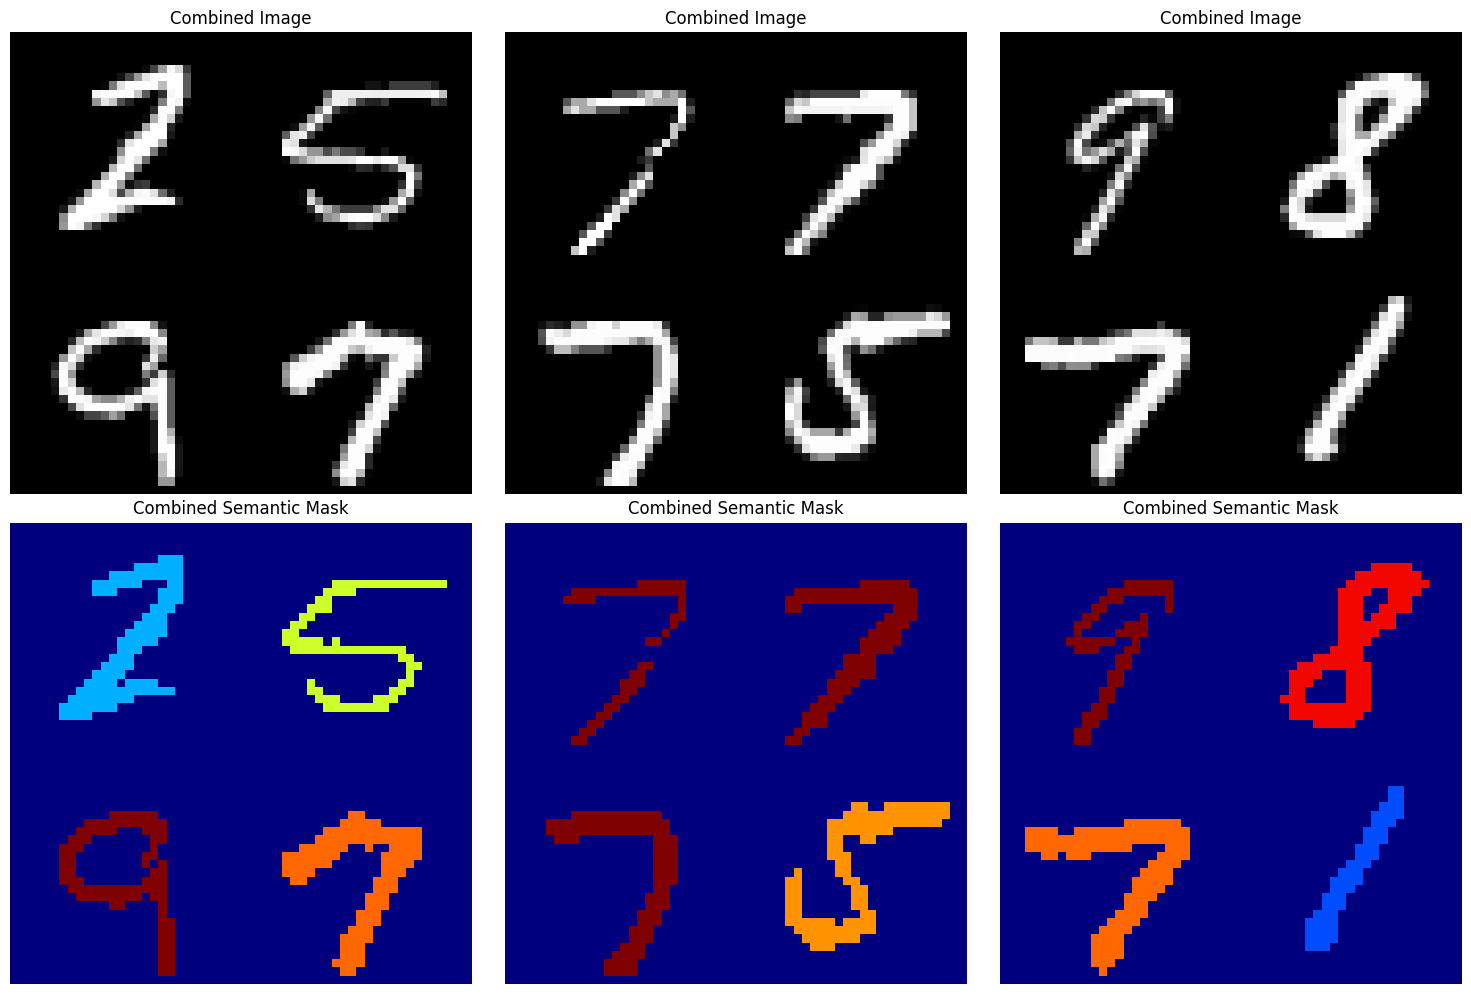

In [1]:
import numpy as np
import cv2
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import math

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Create empty lists to store our new datasets
otsu_masks = []
circle_masks = []
combined_images = []
combined_masks = []

# Function to apply Otsu's thresholding
def apply_otsu_thresholding(image):
    # Apply Otsu's thresholding
    _, binary_mask = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_mask

# Function to find minimum enclosing circle
def get_tight_circle_mask(binary_mask):
    # Convert to proper format for OpenCV
    binary_mask_uint8 = binary_mask.astype(np.uint8)
    
    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create an empty mask
    circle_mask = np.zeros_like(binary_mask_uint8)
    
    if contours:
        # Find the largest contour (should be the digit)
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Find the minimum enclosing circle
        (x, y), radius = cv2.minEnclosingCircle(largest_contour)
        
        # Convert to integer values
        center = (int(x), int(y))
        radius = int(radius)
        
        # Draw the circle on the mask
        cv2.circle(circle_mask, center, radius, 255, -1)
    
    return circle_mask

# Function to create 2x2 combined images and masks
def create_combined_dataset(images, masks, labels, num_samples=10000):
    combined_images = []
    combined_masks = []
    
    for i in range(num_samples):
        # Randomly select 4 images and their corresponding masks
        indices = np.random.choice(len(images), 4, replace=False)
        selected_images = [images[idx] for idx in indices]
        selected_masks = [masks[idx] for idx in indices]
        selected_labels = [labels[idx] for idx in indices]
        
        # Create a 2x2 grid for images and masks
        combined_image = np.zeros((56, 56), dtype=np.uint8)
        combined_mask = np.zeros((56, 56), dtype=np.uint8)
        
        # Place the images and masks in a 2x2 grid
        positions = [(0, 0), (0, 28), (28, 0), (28, 28)]
        
        for j in range(4):
            img = selected_images[j]
            mask = selected_masks[j]
            label = selected_labels[j]
            
            y, x = positions[j]
            combined_image[y:y+28, x:x+28] = img
            # For the mask, we'll use the label value (1-10) instead of binary
            combined_mask[y:y+28, x:x+28] = np.where(mask > 0, label + 1, 0)
        
        combined_images.append(combined_image)
        combined_masks.append(combined_mask)
    
    return np.array(combined_images), np.array(combined_masks)

# Process the training dataset
for i in range(len(train_images)):
    # a) Apply Otsu's thresholding to get foreground segmentation masks
    mask = apply_otsu_thresholding(train_images[i])
    otsu_masks.append(mask)
    
    # b) Get tight circle around the foreground
    circle_mask = get_tight_circle_mask(mask)
    circle_masks.append(circle_mask)

# Convert lists to numpy arrays
otsu_masks = np.array(otsu_masks)
circle_masks = np.array(circle_masks)

# c) Create the combined dataset for semantic segmentation
combined_images, combined_masks = create_combined_dataset(train_images, otsu_masks, train_labels)

# Display examples from each dataset
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Original image, Otsu mask, and Circle mask
for i in range(3):
    idx = np.random.randint(0, len(train_images))
    
    axes[0, i].imshow(train_images[idx], cmap='gray')
    axes[0, i].set_title(f'Original Image (Label: {train_labels[idx]})')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(otsu_masks[idx], cmap='gray')
    axes[1, i].set_title('Otsu Threshold Mask')
    axes[1, i].axis('off')
    
    axes[2, i].imshow(circle_masks[idx], cmap='gray')
    axes[2, i].set_title('Circle Mask')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

# Display examples from the combined dataset
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i in range(3):
    idx = np.random.randint(0, len(combined_images))
    
    axes[0, i].imshow(combined_images[idx], cmap='gray')
    axes[0, i].set_title('Combined Image')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(combined_masks[idx], cmap='jet')
    axes[1, i].set_title('Combined Semantic Mask')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Save the datasets
np.save('mnist_otsu_masks.npy', otsu_masks)
np.save('mnist_circle_masks.npy', circle_masks)
np.save('mnist_combined_images.npy', combined_images)
np.save('mnist_combined_masks.npy', combined_masks)
